# 6. 商品の評価

## 6.1 経営的視点からの商品の管理
### 6.1.1 在庫管理のためのABC分析
### 6.1.2 在庫回転率・在庫回転期間

In [50]:
import math
from itertools import permutations

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

%matplotlib inline

## 6.2 主成分分析による商品の評価

In [2]:
df_id_pos = pd.read_excel('978-4-274-22101-9.xlsx', 'ID付きPOSデータ（POSデータ）')
df_id_pos.head()

,レシートNo,日,時間,顧客ID,税抜価格,税抜単価,個数,大カテゴリ番号,大カテゴリ名,中カテゴリ番号,中カテゴリ名,小カテゴリ番号,小カテゴリ名
0,1,1,9,1518,50,10,5,11,農産,1113,野菜,111327,じゃが芋
1,1,1,9,1518,50,10,5,11,農産,1113,野菜,111363,玉葱
2,1,1,9,1518,90,90,1,11,農産,1113,野菜,111361,レタス
3,1,1,9,1518,185,185,1,11,農産,1113,野菜,111339,トマト
4,2,1,9,1532,85,85,1,11,農産,1113,野菜,111318,キャベツ


In [109]:
df_cat0 = df_id_pos.groupby(['大カテゴリ名']).size()
df_cat0 = df_cat0.sort_values(ascending=False)
df_cat0 = pd.DataFrame(df_cat0, columns=['購買点数'])
df_cat0['累積比率'] = df_cat0['購買点数'].cumsum() / df_cat0['購買点数'].sum()
drop_cat = df_cat0[df_cat0['累積比率'] >= 0.9].index
print(drop_cat.values)
df_day_cat0 = pd.DataFrame(df_id_pos.groupby(['日', '大カテゴリ名']).size().unstack())
df_day_cat0 = df_day_cat0.drop(drop_cat, axis=1)
print(df_day_cat0.columns.values)

# 標準化
# 最後の主成分スコアが標準化される
# 他は標準化しなくても同じ
df_day_cat0 = (df_day_cat0.loc[:] - df_day_cat0.loc[:].mean()) / df_day_cat0.loc[:].std()

df_day_cat0.corr()

['水産' '即席食品' '酒類' '乾物類' 'その他']
['加工食品' '惣菜' '畜産' '穀物類' '菓子' '農産' '飲料']


大カテゴリ名,加工食品,惣菜,畜産,穀物類,菓子,農産,飲料
大カテゴリ名,,,,,,,
加工食品,1.000000,0.342398,0.808284,0.707652,0.468700,0.618176,0.289386
惣菜,0.342398,1.000000,0.140864,0.452519,0.014326,0.007474,0.346865
畜産,0.808284,0.140864,1.000000,0.681233,0.440298,0.574966,0.149606
穀物類,0.707652,0.452519,0.681233,1.000000,0.408245,0.452623,0.351685
菓子,0.468700,0.014326,0.440298,0.408245,1.000000,0.804604,0.293067
農産,0.618176,0.007474,0.574966,0.452623,0.804604,1.000000,0.186354
飲料,0.289386,0.346865,0.149606,0.351685,0.293067,0.186354,1.000000


In [110]:
model = PCA(n_components=2)
model.fit(df_day_cat0.corr())
print('寄与率\n', model.explained_variance_ratio_)
print('因子負荷量\n', model.components_)

寄与率
 [0.60617828 0.26429456]
因子負荷量
 [[-0.26967456  0.47011567 -0.3931905  -0.09196753 -0.43278031 -0.52163758
   0.28949186]
 [-0.41976193 -0.34037802 -0.46624921 -0.45019324  0.39434548  0.18706859
   0.31205359]]


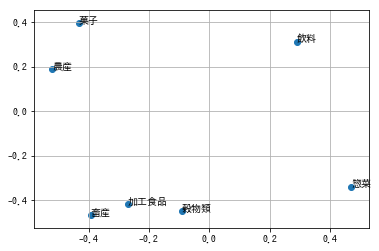

In [111]:
# 図 6.2 ポジショニングマップ・主成分負荷量
plt.scatter(model.components_[0], model.components_[1])
for i, label in enumerate(df_day_cat0.columns.values):
    plt.annotate(label, (model.components_[0][i], model.components_[1][i]))
plt.grid(True)

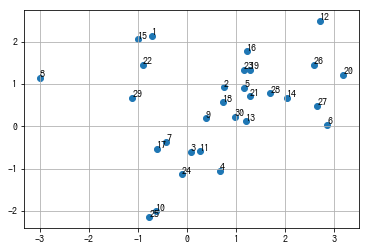

In [112]:
# ポジショニングマップ・主成分得点
scores = model.transform(df_day_cat0).T
plt.scatter(scores[0], scores[1])
for i, label in enumerate(df_day_cat0.index.values):
    plt.annotate(label, (scores[0][i], scores[1][i]))
plt.grid(True)

## 6.3 相関ルール分析

In [78]:
cat = df_id_pos['小カテゴリ名'].unique()
cat_count = cat.size
u = df_id_pos['レシートNo'].unique().size

result = []
cache = {}
for c in permutations(cat, 2):
    if c[0] in cache:
        set_a_count = cache[c[0]]
    else:
        set_a = set(df_id_pos[df_id_pos['小カテゴリ名'] == c[0]]['レシートNo'])
        set_a_count = len(set_a)
        cache[c[0]] = set_a_count
    if c[1] in cache:
        set_b_count = cache[c[1]]
    else:
        set_b = set(df_id_pos[df_id_pos['小カテゴリ名'] == c[1]]['レシートNo'])
        set_b_count = len(set_b)
        cache[c[1]] = set_b_count
    if c in cache:
        set_ab_count = cache[c]
    else:
        set_ab = set_a & set_b
        set_ab_count = len(set_ab)
        cache[c] = set_ab_count
        cache[(c[1], c[0])] = set_ab_count
    e = {
        'pair': c,
        'support': set_ab_count / u,
        'confidence': set_ab_count / set_a_count,
        'lift': confidence / (set_b_count / u)
    }
    # supportが0.5%以上を対象としてみる
    if e['support'] >= 0.005:
        result.append(e)

support10 = sorted(result, key=lambda e: e['support'], reverse=True)[:10]
confidence10 = sorted(result, key=lambda e: e['confidence'], reverse=True)[:10]
lift10 = sorted(result, key=lambda e: e['lift'], reverse=True)[:10]

In [79]:
def to_dataframe(a):
    df = pd.DataFrame(columns=('support', 'confidence', 'lift'))
    for e in a:
        df.loc[str(e['pair'])] = (e['support'], e['confidence'], e['lift'])
    return df

In [80]:
# support降順
to_dataframe(support10)

,support,confidence,lift
"('じゃが芋', '玉葱')",0.024721,0.497126,14.081881
"('玉葱', 'じゃが芋')",0.024721,0.348089,20.111193
"('じゃが芋', '豆腐')",0.013004,0.261494,6.033358
"('豆腐', 'じゃが芋')",0.013004,0.078448,20.111193
"('じゃが芋', '鶏卵')",0.011718,0.235632,7.690874
"('鶏卵', 'じゃが芋')",0.011718,0.090110,20.111193
"('じゃが芋', 'トマト')",0.010574,0.212644,13.130760
"('トマト', 'じゃが芋')",0.010574,0.138837,20.111193
"('じゃが芋', 'ブランド豚')",0.010289,0.206897,7.716312
"('ブランド豚', 'じゃが芋')",0.010289,0.079383,20.111193


In [81]:
# confidence降順
to_dataframe(confidence10)

,support,confidence,lift
"('じゃが芋', '玉葱')",0.024721,0.497126,14.081881
"('玉葱', 'じゃが芋')",0.024721,0.348089,20.111193
"('じゃが芋', '豆腐')",0.013004,0.261494,6.033358
"('じゃが芋', '鶏卵')",0.011718,0.235632,7.690874
"('じゃが芋', 'トマト')",0.010574,0.212644,13.130760
"('じゃが芋', 'ブランド豚')",0.010289,0.206897,7.716312
"('人参', 'じゃが芋')",0.009717,0.198830,20.111193
"('じゃが芋', '人参')",0.009717,0.195402,20.464020
"('じゃが芋', 'ヨーグルト')",0.009145,0.183908,7.453349
"('じゃが芋', '牛乳')",0.008860,0.178161,7.019754


In [82]:
# lift降順
to_dataframe(lift10)

,support,confidence,lift
"('じゃが芋', 'しめじ')",0.005430,0.109195,24.050498
"('じゃが芋', '大根')",0.005001,0.100575,21.600911
"('じゃが芋', 'キャベツ')",0.007716,0.155172,21.272629
"('じゃが芋', '人参')",0.009717,0.195402,20.464020
"('玉葱', 'じゃが芋')",0.024721,0.348089,20.111193
"('トマト', 'じゃが芋')",0.010574,0.138837,20.111193
"('キャベツ', 'じゃが芋')",0.007716,0.164134,20.111193
"('キュウリ', 'じゃが芋')",0.008574,0.091884,20.111193
"('炭酸飲料', 'じゃが芋')",0.006430,0.054414,20.111193
"('菓子パン', 'じゃが芋')",0.007859,0.051643,20.111193


## 6.4 コジョイント分析による新商品企画の最適化

In [2]:
df_profile = pd.read_excel('978-4-274-22101-9.xlsx', 'プロファイル評価データ')
df_profile

,被験者,プロファイル,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,プロファイル.1,因子1,因子2,因子3,因子4,因子5,因子6
0,NaN,A,B,C,D,E,F,G,H,NaN,A,1,1,1,1,1,1
1,1.0,68,85,64,37,54,18,97,55,NaN,B,1,1,1,2,2,2
2,2.0,64,76,34,26,69,25,88,82,NaN,C,1,2,2,1,1,2
3,3.0,38,53,95,44,43,82,23,17,NaN,D,1,2,2,2,2,1
4,4.0,61,76,32,37,17,23,96,71,NaN,E,2,1,2,1,2,1
5,5.0,56,83,75,52,27,35,83,32,NaN,F,2,1,2,2,1,2
6,6.0,44,74,73,57,18,44,86,18,NaN,G,2,2,1,1,2,2
7,7.0,88,74,57,84,19,37,39,51,NaN,H,2,2,1,2,1,1
8,8.0,85,86,46,52,22,34,71,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9.0,82,83,53,39,42,35,63,66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
# ユーザー 1-15 のプロファイル評価
df_profile_eval = df_profile.iloc[1:17, 1:9]
df_profile_eval.columns = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
df_profile_eval

,A,B,C,D,E,F,G,H
1,68,85,64,37,54,18,97,55
2,64,76,34,26,69,25,88,82
3,38,53,95,44,43,82,23,17
4,61,76,32,37,17,23,96,71
5,56,83,75,52,27,35,83,32
6,44,74,73,57,18,44,86,18
7,88,74,57,84,19,37,39,51
8,85,86,46,52,22,34,71,65
9,82,83,53,39,42,35,63,66
10,13,86,24,45,21,68,88,52


In [129]:
# 直交表 L_8(2^6)
df_factors = df_profile.iloc[0:8, 10:17].set_index('プロファイル.1')
df_factors.index.name = None
df_factors.columns = ['消費電力', '重量', '髪つや出し機能', '付属アタッチメント', '形状', '髪保護機能']
df_factors

,消費電力,重量,髪つや出し機能,付属アタッチメント,形状,髪保護機能
A,1,1,1,1,1,1
B,1,1,1,2,2,2
C,1,2,2,1,1,2
D,1,2,2,2,2,1
E,2,1,2,1,2,1
F,2,1,2,2,1,2
G,2,2,1,1,2,2
H,2,2,1,2,1,1


In [131]:
# 因子と水準(1-2)
df_factor_level = df_profile.iloc[11:13, 11:17].rename(index={11: 1, 12: 2})
df_factor_level.columns = ['消費電力', '重量', '髪つや出し機能', '付属アタッチメント', '形状', '髪保護機能']
df_factor_level

,消費電力,重量,髪つや出し機能,付属アタッチメント,形状,髪保護機能
1,1000W,500g,なし,なし,なし,なし
2,1200W,800g,あり,あり,あり,あり


In [96]:
# 因子毎に水準を１つ除く
# 2水準なので 2 を 0 にしただけと同値
df_factors_dummy = pd.get_dummies(df_factors[df_factors.columns])[['消費電力_1', '重量_1', '髪つや出し機能_1', '付属アタッチメント_1', '形状_1', '髪保護機能_1']]
df_factors_dummy

,消費電力_1,重量_1,髪つや出し機能_1,付属アタッチメント_1,形状_1,髪保護機能_1
プロファイル.1,,,,,,
A,1,1,1,1,1,1
B,1,1,1,0,0,0
C,1,0,0,1,1,0
D,1,0,0,0,0,1
E,0,1,0,1,0,1
F,0,1,0,0,1,0
G,0,0,1,1,0,0
H,0,0,1,0,1,1


In [101]:
# 部分効用値の算出
# ユーザーのプロファイルい対する評価が、（コジョイントカード相当の）df_factors_dummyの線型結合で説明できるとして重回帰分析
# 水準を一つ落としているので最後にカテゴリ変量の調整してそれを部分効用値とする
X = []
Y = []
for c in df_profile_eval.columns:
    Y.extend(df_profile_eval[c].values)
    X.extend([df_factors_dummy.loc[c].values] * len(df_profile_eval[c]))
model = LinearRegression()
model.fit(X, Y)

# beta_jk - 1/q (\sum^{q-1}_{m=1} beta_jm) で q=2 のケース
coef_adjusted = model.coef_ - model.coef_ / 2
coef_adjusted

array([ 6.4       , -2.26666667, 10.71666667,  0.81666667, -2.1       ,
       -4.73333333])

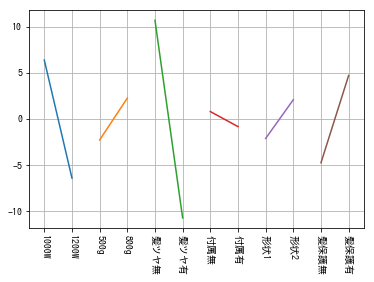

In [114]:
# 部分効用値グラフ
for i, ca in enumerate(coef_adjusted):
    plt.plot([i * 2, i * 2 + 1], [ca, -ca])
plt.xticks(range(12),
           ['1000W', '1200W', '500g', '800g', '髪ツヤ無', '髪ツヤ有', '付属無', '付属有', '形状1', '形状2', '髪保護無', '髪保護有'],
           rotation=-90)
plt.grid(True)

([<matplotlib.patches.Wedge at 0x7f13324c2a58>,
 [Text(0.809524,0.744762,'消費電力: 24.0%'),
  Text(-0.197071,1.0822,'重量: 8.0%'),
  Text(-1.09233,-0.129661,'髪つや出し機能: 40.0%'),
  Text(-0.123312,-1.09307,'付属アタッチメント: 3.0%'),
  Text(0.247146,-1.07188,'形状: 8.0%'),
  Text(0.937737,-0.575021,'髪保護機能: 18.0%')])

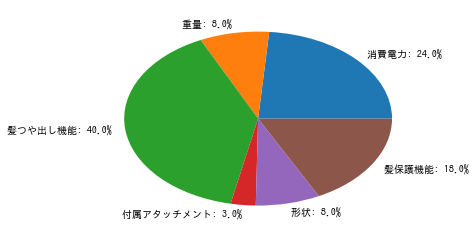

In [113]:
# 因子間影響度比較
x = abs(coef_adjusted) / abs(coef_adjusted).sum()
labels = []
for i, label in enumerate(df_factor_level.columns.values):
    labels.append('{}: {}%'.format(label, round(x[i] * 100)))
plt.pie(x, labels=labels)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f13336645f8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1333664eb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f13336644a8>,
 'medians': [<matplotlib.lines.Line2D at 0x7f133368d748>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f133368db70>,
 'means': []}

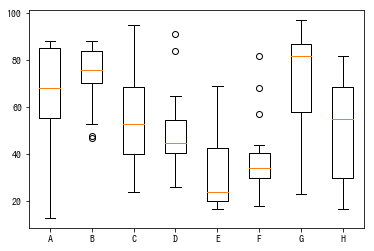

In [117]:
# プロファイル評価箱ひげ図
labels = [chr(i) for i in range(65, 65+8)]
plt.boxplot(df_profile_eval.values, labels=labels)